### Imports and helper functions

In [1]:
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from itertools import cycle

In [28]:
def visualize_points(pts):
    plt.plot(pts[:, 0], pts[:, 1], '.', alpha=0.5)
    plt.axis('equal')
    plt.grid()

    return plt

In [40]:
def create_ellipse_points(mean, cov, n_std=1.96, n_points=100):
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    angle = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0])
    
    t = np.linspace(0, 2*np.pi, n_points)
    ellipse_x = n_std * np.sqrt(eigenvalues[0]) * np.cos(t)
    ellipse_y = n_std * np.sqrt(eigenvalues[1]) * np.sin(t)
    
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle), np.cos(angle)]])
    
    ellipse_points = np.dot(np.column_stack([ellipse_x, ellipse_y]), R.T) + mean
    return ellipse_points[:, 0], ellipse_points[:, 1]

def plot_confidence_ellipses(distributions, n_std=1.96):
    fig, ax = plt.subplots()

    cmap = plt.get_cmap('viridis')
    colors = cycle(cmap(np.linspace(0, 1, len(distributions))))
    patches = []

    for idx, dist in enumerate(distributions):
        mean, cov = dist[0], np.array([dist[1], dist[2]])
        x, y = create_ellipse_points(mean, cov, n_std)
        
        color = next(colors)
        
        # Create polygon
        polygon_points = np.column_stack([x, y])
        poly = Polygon(polygon_points, closed=True, fill=True, color=color, alpha=0.5)
        ax.add_patch(poly)
        patches.append(poly)

    ax.set_title('Confidence Ellipses')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend(patches, ['Distribution {}'.format(i) for i in range(len(distributions))])
    ax.axis('equal')

    return plt, ax

def plot_distributions_with_points(distributions, points, n_std=1.96):
    fig, ax = plot_confidence_ellipses(distributions, n_std)
    
    ax.plot(points[:, 0], points[:, 1], 'ko')

    return plt

### Code

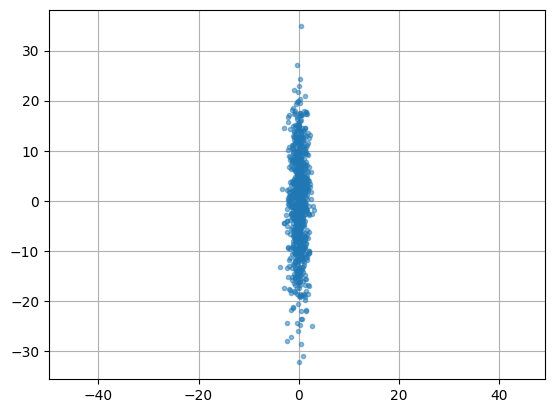

In [29]:
mean = [0, 0]
cov = [[1, 0], [0, 100]]
pts = np.random.multivariate_normal(mean, cov, size=800)

visualize_points(pts).show()

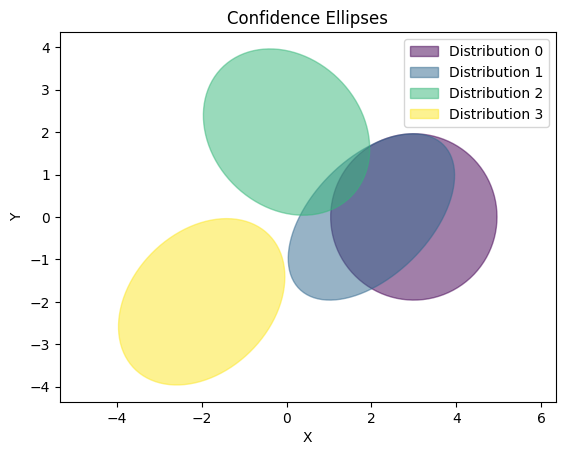

In [62]:
# each row has the values for mutlivariate normal distributions
distributions = np.array([
    [[3, 0], [1, 0], [0, 1]],
    [[2, 0], [1, 0.5], [0.5, 1]],
    [[0, 2], [1, -0.2], [-0.2, 1]],
    [[-2, -2], [1, 0.3], [0.3, 1]]
])

plot_confidence_ellipses(distributions)[0].show()

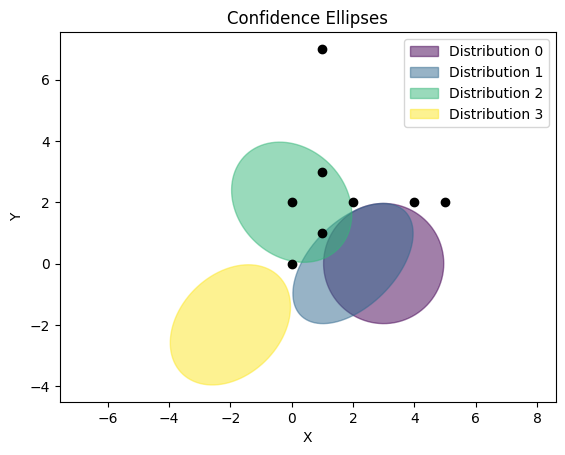

In [76]:
points = np.array([
    [0, 0],
    [1, 1],
    [2, 2],
    [4, 2],
    [1, 3],
    [0, 2],
    [1, 7],
    [5, 2]
])

plot_distributions_with_points(distributions, points).show()

### Points to Distribution

In [77]:
def calc_likelihoods_for_distributions_and_points(matrix_dist, matrix_points):
    means = distributions[:, 0]
    covariances = distributions[:, 1:]

    likelihoods = np.array([multivariate_normal(mean=means[i], cov=covariances[i]).pdf(points) for i in range(len(means))])
    return likelihoods.T 

In [99]:
likelihoods = calc_likelihoods_for_distributions_and_points(distributions, points)
likelihoods

array([[1.76805171e-03, 1.27694115e-02, 2.02257365e-02, 7.69145887e-03],
       [1.30642333e-02, 2.48714174e-02, 7.05947569e-02, 1.64302938e-04],
       [1.30642333e-02, 1.27694115e-02, 2.02257365e-02, 7.53592524e-07],
       [1.30642333e-02, 1.27694115e-02, 3.90448566e-05, 1.77853243e-10],
       [2.39279779e-04, 3.16522065e-05, 4.65389320e-02, 1.80599229e-07],
       [2.39279779e-04, 6.16500800e-05, 1.62436834e-01, 3.93753694e-05],
       [4.93192384e-13, 5.76898205e-18, 7.53743050e-08, 4.09163437e-19],
       [2.91502447e-03, 1.72815192e-03, 3.59590698e-07, 5.25598800e-13]])

In [73]:
np.log(likelihoods)

array([[ -6.33787707,  -4.3607027 ,  -3.9007994 ,  -4.8676448 ],
       [ -4.33787707,  -3.69403603,  -2.6507994 ,  -8.71379865],
       [ -4.33787707,  -4.3607027 ,  -3.9007994 , -14.09841403]])

In [79]:
sorted_indices = np.argsort(likelihoods, axis=0)

# Create a ranking matrix based on sorted indices
ranks = np.zeros_like(likelihoods, dtype=int)

# Use np.arange to create integer ranks and use advanced indexing to place them in the correct order
n_rows, n_cols = likelihoods.shape
ranks[sorted_indices, np.arange(n_cols)] = np.tile(np.arange(n_rows), (n_cols, 1)).T
n_rows - ranks

array([[5, 4, 5, 1],
       [3, 1, 2, 2],
       [2, 3, 4, 4],
       [1, 2, 6, 6],
       [7, 7, 3, 5],
       [6, 6, 1, 3],
       [8, 8, 8, 8],
       [4, 5, 7, 7]])

In [173]:
mask  = np.array((n_rows - ranks) <= n_cols)
mask_binary = np.array((n_rows - ranks) <= n_cols, dtype=int)
mask

array([[False,  True, False,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True, False, False],
       [False, False,  True, False],
       [False, False,  True,  True],
       [False, False, False, False],
       [ True, False, False, False]])

In [176]:
# find points that where in the top s results of each likelihood
points_to_consider = np.where(np.any(mask, axis=1))[0]
points_to_consider

array([0, 1, 2, 3, 4, 5, 7])

In [178]:
filtered_points = points[points_to_consider]
filtered_points

array([[0, 0],
       [1, 1],
       [2, 2],
       [4, 2],
       [1, 3],
       [0, 2],
       [5, 2]])

In [179]:
likelihoods = calc_likelihoods_for_distributions_and_points(distributions, filtered_points)
likelihoods

array([[1.76805171e-03, 1.27694115e-02, 2.02257365e-02, 7.69145887e-03],
       [1.30642333e-02, 2.48714174e-02, 7.05947569e-02, 1.64302938e-04],
       [1.30642333e-02, 1.27694115e-02, 2.02257365e-02, 7.53592524e-07],
       [1.30642333e-02, 1.27694115e-02, 3.90448566e-05, 1.77853243e-10],
       [2.39279779e-04, 3.16522065e-05, 4.65389320e-02, 1.80599229e-07],
       [2.39279779e-04, 6.16500800e-05, 1.62436834e-01, 3.93753694e-05],
       [4.93192384e-13, 5.76898205e-18, 7.53743050e-08, 4.09163437e-19],
       [2.91502447e-03, 1.72815192e-03, 3.59590698e-07, 5.25598800e-13]])

In [189]:
percentage_of_likelihood = np.log(likelihoods)/ np.sum(np.log(likelihoods), axis=0)
percentage_of_likelihood

array([[0.09027927, 0.05261109, 0.06876415, 0.03324583],
       [0.06179047, 0.04456788, 0.04672887, 0.05951492],
       [0.06179047, 0.05261109, 0.06876415, 0.09629164],
       [0.06179047, 0.05261109, 0.17894051, 0.15333309],
       [0.11876807, 0.125     , 0.05407396, 0.10604873],
       [0.11876807, 0.11695679, 0.03203869, 0.06927201],
       [0.40365612, 0.47890135, 0.28911688, 0.28918179],
       [0.08315707, 0.07674073, 0.26157279, 0.19311199]])

In [190]:
log_neg_percentage_of_likelihood = np.log(percentage_of_likelihood)
log_neg_percentage_of_likelihood

array([[-2.40484742, -2.94482839, -2.67707281, -3.40382587],
       [-2.78400621, -3.11074197, -3.06339306, -2.82152826],
       [-2.78400621, -2.94482839, -2.67707281, -2.34037377],
       [-2.78400621, -2.94482839, -1.72070186, -1.87514269],
       [-2.13058265, -2.07944154, -2.91740248, -2.24385657],
       [-2.13058265, -2.14595075, -3.44081106, -2.66971437],
       [-0.90719196, -0.73626065, -1.24092424, -1.24069975],
       [-2.48702407, -2.56732275, -1.34104268, -1.644485  ]])

In [192]:
from scipy.optimize import linear_sum_assignment

row_ind, col_ind = linear_sum_assignment(log_neg_percentage_of_likelihood)
assignments = list(zip(row_ind, col_ind))
assignments

[(0, 3), (1, 1), (2, 0), (5, 2)]

In [117]:
mask_binary = np.array((n_rows - ranks) <= n_cols, dtype=int)
mask_int = np.copy(mask_binary)
mask_int[:, 1] *= 2
mask_int[:, 2] *= 3
mask_int[:, 3] *= 4
mask_int

array([[0, 2, 0, 4],
       [1, 2, 3, 4],
       [1, 2, 3, 4],
       [1, 2, 0, 0],
       [0, 0, 3, 0],
       [0, 0, 3, 4],
       [0, 0, 0, 0],
       [1, 0, 0, 0]])

In [118]:
mask_binary

array([[0, 1, 0, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 1],
       [0, 0, 0, 0],
       [1, 0, 0, 0]])

In [121]:
cumsum_array = np.cumsum(mask_binary, axis=0)

In [152]:
indices = np.column_stack((mask_int.flatten(), cumsum_array.flatten()))
indices

array([[0, 0],
       [2, 1],
       [0, 0],
       [4, 1],
       [1, 1],
       [2, 2],
       [3, 1],
       [4, 2],
       [1, 2],
       [2, 3],
       [3, 2],
       [4, 3],
       [1, 3],
       [2, 4],
       [0, 2],
       [0, 3],
       [0, 3],
       [0, 4],
       [3, 3],
       [0, 3],
       [0, 3],
       [0, 4],
       [3, 4],
       [4, 4],
       [0, 3],
       [0, 4],
       [0, 4],
       [0, 4],
       [1, 4],
       [0, 4],
       [0, 4],
       [0, 4]])

In [112]:
mask_int.flatten()

array([0, 2, 0, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 0, 0, 0, 0, 3, 0, 0, 0,
       3, 4, 0, 0, 0, 0, 1, 0, 0, 0])

In [84]:
mask.shape

(8, 4)

In [138]:
flat_likelihoods = likelihoods.flatten()
flat_likelihoods

array([1.76805171e-03, 1.27694115e-02, 2.02257365e-02, 7.69145887e-03,
       1.30642333e-02, 2.48714174e-02, 7.05947569e-02, 1.64302938e-04,
       1.30642333e-02, 1.27694115e-02, 2.02257365e-02, 7.53592524e-07,
       1.30642333e-02, 1.27694115e-02, 3.90448566e-05, 1.77853243e-10,
       2.39279779e-04, 3.16522065e-05, 4.65389320e-02, 1.80599229e-07,
       2.39279779e-04, 6.16500800e-05, 1.62436834e-01, 3.93753694e-05,
       4.93192384e-13, 5.76898205e-18, 7.53743050e-08, 4.09163437e-19,
       2.91502447e-03, 1.72815192e-03, 3.59590698e-07, 5.25598800e-13])

In [157]:
s = min(n_rows, n_cols)
extended_likelihood_entries = np.zeros((s+1, n_cols + 1))

In [160]:
extended_likelihood_entries[indices[:, 1], indices[:, 0]] = flat_likelihoods
likelihood_entries = extended_likelihood_entries[1:, 1:]

In [161]:
likelihood_entries

array([[1.30642333e-02, 1.27694115e-02, 7.05947569e-02, 7.69145887e-03],
       [1.30642333e-02, 2.48714174e-02, 2.02257365e-02, 1.64302938e-04],
       [1.30642333e-02, 1.27694115e-02, 4.65389320e-02, 7.53592524e-07],
       [2.91502447e-03, 1.27694115e-02, 1.62436834e-01, 3.93753694e-05]])

In [166]:
np.log(likelihood_entries)

array([[ -4.33787707,  -4.3607027 ,  -2.6507994 ,  -4.8676448 ],
       [ -4.33787707,  -3.69403603,  -3.9007994 ,  -8.71379865],
       [ -4.33787707,  -4.3607027 ,  -3.06746607, -14.09841403],
       [ -5.83787707,  -4.3607027 ,  -1.81746607, -10.14237008]])

In [170]:
percentage_of_likelihood = np.log(likelihood_entries)/ np.sum(np.log(likelihood_entries), axis=0) * 100
percentage_of_likelihood

array([[23.01076925, 25.99347422, 23.17835203, 12.86979937],
       [23.01076925, 22.01957735, 34.10823983, 23.03882984],
       [23.01076925, 25.99347422, 26.82164797, 37.2754725 ],
       [30.96769226, 25.99347422, 15.89176017, 26.8158983 ]])

### Assign points to distributions

Give a set of $N$ multivariate normal distributions and a set of $M$ points ${(x_i,y_i)}_{M}$. The problem we want to solve can be formulated as:
- find a subset of points 

### Gaussian Processes